<h1 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 2px 2px #D1D1D1;">
    Model Optimization (MO) for Workers' Compensation Claims
</h1>
<hr style="border: 2px solid #4A90E2;">

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 2px 2px #D1D1D1;">Required Imports</h2>

<hr style="border: 2px solid #4A90E2;">

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">Package Descriptions</h3>
<ul style="font-family: 'Arial', sans-serif;">
    <li><strong>pandas</strong>: For data manipulation and analysis, enabling easy reading and handling of dataframes.</li>
    <li><strong>numpy</strong>: For efficient numerical operations and array manipulation.</li>
    <li><strong>matplotlib.pyplot</strong>: To create data visualizations and plots.</li>
    <li><strong>seaborn</strong>: For generating attractive and informative statistical visualizations.</li>
    <li><strong>missingno</strong>: For visualizing and analyzing missing data, helping to better understand data quality.</li>
</ul>


In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import missingno as msng # type: ignore
import sys # type: ignore
import os # type: ignore

from scipy import stats # type: ignore
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE # type: ignore
from keras.utils import to_categorical


sys.path.append(os.path.abspath("../utils"))
from meta_model_train import meta_model_rf, meta_model_xgbc, meta_model_et
from neural_network import neural_network
from plots import plot_training_history, plot_confusion_matrix
from predicitons_csv import save_predictions_to_csv
from save_models import save_model

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Data Loading
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    This section handles loading the dataset into the environment for further processing. Using <strong>pandas</strong>, we load the data into a structured dataframe, allowing for easy manipulation, exploration, and analysis throughout the project.
</p>


In [2]:
path = "../data/"

X_train = pd.read_csv(path + "X_train_post_FS.csv")
X_val = pd.read_csv(path + "X_val_post_FS.csv")

y_train = pd.read_csv(path + "y_train_post_FS.csv")
y_val = pd.read_csv(path + 'y_val_post_FS.csv')

data_test = pd.read_csv(path + "data_test_post_FS.csv")

data = pd.read_csv(path + "Claim_Injury_Type_mapping.csv")

In [3]:
mapping_dict = dict(zip(data['Encoded Value'], data['Claim Injury Type']))

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Data Scaling
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    In this section, we do data scaling is applied to normalize features, ensuring that all variables contribute equally to the model without being impacted by differing scales. This step is crucial for algorithms sensitive to feature magnitudes, such as regression and distance-based models.
</p>


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Data Scaling
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Data scaling is an essential preprocessing step to standardize the range of independent variables. By scaling features, we ensure that all variables contribute equally to model training, avoiding bias toward features with larger scales. Scaling is particularly important for algorithms sensitive to feature magnitudes, such as gradient-based methods and distance-based models.
</p>


In [4]:
# Initialize the scaler
scaler = StandardScaler()

In [5]:
# Fit the scaler on the training data (this step calculates the mean and std dev of X_train only)
scaler.fit(X_train)

StandardScaler()

In [6]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [7]:
# Transform the validation data using the same scaler (without fitting)
X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

In [8]:
# If you also want to scale the test data in the same manner:
X_test_scaled = scaler.transform(data_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=data_test.columns)

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Model Selection
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    This section focuses on selecting the best-performing models for predicting workers' compensation claims outcomes. Various machine learning algorithms are evaluated based on their accuracy, interpretability, and suitability for the dataset, ensuring an optimal balance between predictive performance and computational efficiency.
</p>


In [9]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

  File "d:\Repositories\TGNTG_ML\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 1420, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


In [10]:
def meta_model_run(model, X_train_resampled=None, y_train_resampled=None, data_test_FS=None, n_splits=5):
    if X_train_resampled is None or y_train_resampled is None or data_test_FS is None:
        raise ValueError("Os dados de treinamento e teste precisam ser fornecidos.")

    if model == "RandomForest":
        models, f1_scores, oof_predictions, test_predictions = meta_model_rf(
            X_train_resampled, y_train_resampled, data_test_FS, n_splits_n=n_splits
        )
    elif model == "XGBoost":
        models, f1_scores, oof_predictions, test_predictions = meta_model_xgbc(
            X_train_resampled, y_train_resampled, data_test_FS, n_splits_n=n_splits
        )
    elif model == "ExtraTree":
        models, f1_scores, oof_predictions, test_predictions = meta_model_et(
            X_train_resampled, y_train_resampled, data_test_FS, n_splits_n=n_splits
        )
    else:
        raise ValueError("Modelo inválido. Escolha entre 'RandomForest', 'XGBoost' ou 'ExtraTree'.")

    return oof_predictions, test_predictions


<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 32px; text-shadow: 2px 2px #D1D1D1;">Claim Injury Type Prediction(Without Agreement Reached and WCB Decision)</h3>

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">CatBoost Classifier</h3>

In [203]:
#oof_predictions, test_predictions = meta_model_run(
#    model="CatBoost",
#    X_train_resampled=X_train_resampled,
#    y_train_resampled=y_train_resampled,
#    data_test_FS=data_test_FS
#)


In [204]:
#nn_model, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(oof_predictions, y_train_resampled)

#history = nn_model.fit(
#    X_nn_train, y_nn_train,
#    validation_data=(X_nn_val, y_nn_val),
#    epochs=10,
#    batch_size=64,
#    callbacks=[early_stopping, reduce_lr],
#    verbose=1
#)

In [205]:
#plot_training_history(history)

In [206]:
#plot_confusion_matrix(model=nn_model, X_val=X_nn_val, y_val=y_nn_val,
#    class_mapping={
#        0: '2. NON-COMP',
#        1: '4. TEMPORARY',
#       2: '3. MED ONLY',
#        3: '5. PPD SCH LOSS',
#        4: '6. PPD NSL',
#        5: '1. CANCELLED',
#        6: '8. DEATH',
#        7: '7. PTD'
#    }, title="Matriz de Confusão - Conjunto de Validação"
#)

In [207]:
#save_predictions_to_csv(
#    model=nn_model,
#    test_data=test_predictions,
#    claim_ids=data_test_FS["Claim Identifier"],
#    class_mapping={
#       0: '2. NON-COMP',
#        1: '4. TEMPORARY',
#        2: '3. MED ONLY',
#        3: '5. PPD SCH LOSS',
#        4: '6. PPD NSL',
#        5: '1. CANCELLED',
#        6: '8. DEATH',
#        7: '7. PTD'
#    },
#    output_path="../predictions/group_40_KFold_CatBoost_NN_predictions.csv"
#)


In [208]:
#predicitons_data = pd.read_csv('../predictions/group_40_KFold_CatBoost_NN_predictions.csv')
#values = predicitons_data['Claim Injury Type'].value_counts()
#values

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">Random Forest Classifier</h3>

In [209]:
oof_predictions_rf, test_predictions_rf = meta_model_run(
    model="RandomForest",
    X_train_resampled=X_train_resampled,
    y_train_resampled=y_train_resampled,
    data_test_FS=data_test,
    n_splits=5
)

Training Fold 1...
Macro F1-Score do Fold 1: 0.9349
Training Fold 2...
Macro F1-Score do Fold 2: 0.9346
Training Fold 3...
Macro F1-Score do Fold 3: 0.9344
Training Fold 4...
Macro F1-Score do Fold 4: 0.9339
Training Fold 5...
Macro F1-Score do Fold 5: 0.9347
Treinamento concluído em 62.22 minutos.


In [210]:
nn_model_rf, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(oof_predictions_rf, y_train_resampled)

history = nn_model_rf.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

save_model(nn_model_rf, "RF_NN_model")

Epoch 1/10
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 92s 4ms/step - accuracy: 0.9343 - loss: 0.2013 - val_accuracy: 0.9434 - val_loss: 0.1595 - learning_rate: 0.0010
Epoch 2/10
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 87s 4ms/step - accuracy: 0.9401 - loss: 0.1741 - val_accuracy: 0.9439 - val_loss: 0.1584 - learning_rate: 0.0010
Epoch 3/10
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9410 - loss: 0.1710 - val_accuracy: 0.9442 - val_loss: 0.1576 - learning_rate: 0.0010
Epoch 4/10
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - accuracy: 0.9410 - loss: 0.1702 - val_accuracy: 0.9442 - val_loss: 0.1584 - learning_rate: 0.0010
Epoch 5/10
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - accuracy: 0.9414 - loss: 0.1688 - val_accuracy: 0.9440 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 6/10
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - accuracy: 0.9416 - loss: 0.1687 - val_accuracy: 0.9441 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 7/10
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 85s 4ms/step -

'../models/RF_NN_model.pkl'

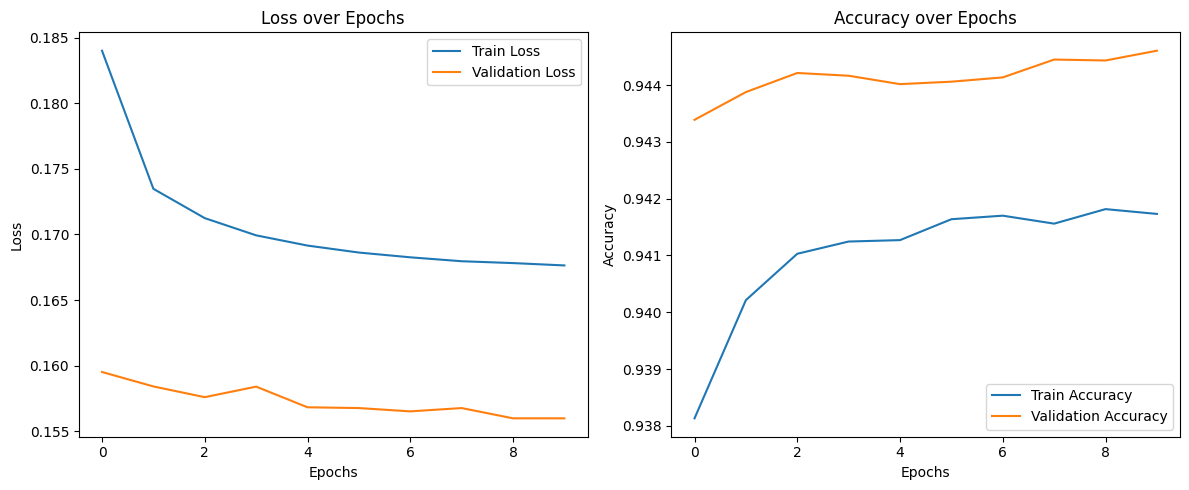

In [211]:
plot_training_history(history)

11638/11638 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step


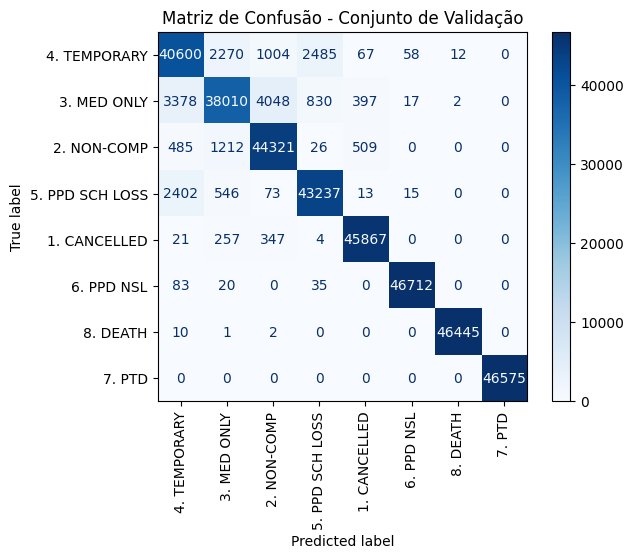

                 precision    recall  f1-score   support

   4. TEMPORARY       0.86      0.87      0.87     46496
    3. MED ONLY       0.90      0.81      0.85     46682
    2. NON-COMP       0.89      0.95      0.92     46553
5. PPD SCH LOSS       0.93      0.93      0.93     46286
   1. CANCELLED       0.98      0.99      0.98     46496
     6. PPD NSL       1.00      1.00      1.00     46850
       8. DEATH       1.00      1.00      1.00     46458
         7. PTD       1.00      1.00      1.00     46575

       accuracy                           0.94    372396
      macro avg       0.94      0.94      0.94    372396
   weighted avg       0.94      0.94      0.94    372396



In [212]:
plot_confusion_matrix(model=nn_model_rf, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping=mapping_dict, title="Matriz de Confusão - Conjunto de Validação"
)

In [213]:
save_predictions_to_csv(
    model=nn_model_rf,
    test_data=test_predictions_rf,
    claim_ids=data_test["Claim Identifier"],
    class_mapping=mapping_dict,
    output_path="../predictions/group_40_KFold_RF_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
Predições salvas em '../predictions/group_40_KFold_RF_NN_predictions.csv'.


In [214]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_RF_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
4. TEMPORARY       351467
2. NON-COMP         36472
5. PPD SCH LOSS        23
3. MED ONLY            13
Name: count, dtype: int64

: 

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">XGBoost Classifier</h3>

In [ ]:
oof_predictions_xgbc, test_predictions_xgbc = meta_model_run(
    model="XGBoost",
    X_train_resampled=X_train_resampled,
    y_train_resampled=y_train_resampled,
    data_test_FS=data_test,
    n_splits=5
)

Training Fold 1...
Macro F1-Score do Fold 1: 0.8983
Training Fold 2...
Macro F1-Score do Fold 2: 0.8977
Training Fold 3...
Macro F1-Score do Fold 3: 0.8988
Training Fold 4...
Macro F1-Score do Fold 4: 0.8975
Training Fold 5...


In [ ]:
nn_model_xgbc, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(oof_predictions_xgbc, y_train_resampled)

history = nn_model_xgbc.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

save_model(nn_model_xgbc, "XGBoost_NN_model")

Epoch 1/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 95s 4ms/step - accuracy: 0.8778 - loss: 0.3541 - val_accuracy: 0.8867 - val_loss: 0.3037 - learning_rate: 0.0010
Epoch 2/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 89s 4ms/step - accuracy: 0.8827 - loss: 0.3219 - val_accuracy: 0.8867 - val_loss: 0.3026 - learning_rate: 0.0010
Epoch 3/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 96s 4ms/step - accuracy: 0.8837 - loss: 0.3176 - val_accuracy: 0.8868 - val_loss: 0.3030 - learning_rate: 0.0010
Epoch 4/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 93s 4ms/step - accuracy: 0.8843 - loss: 0.3153 - val_accuracy: 0.8870 - val_loss: 0.3012 - learning_rate: 0.0010
Epoch 5/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - accuracy: 0.8838 - loss: 0.3163 - val_accuracy: 0.8872 - val_loss: 0.3023 - learning_rate: 0.0010
Epoch 6/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 90s 4ms/step - accuracy: 0.8844 - loss: 0.3150 - val_accuracy: 0.8871 - val_loss: 0.3009 - learning_rate: 0.0010
Epoch 7/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 92s 4ms/step -

'../models/XGBoost_NN_model.pkl'

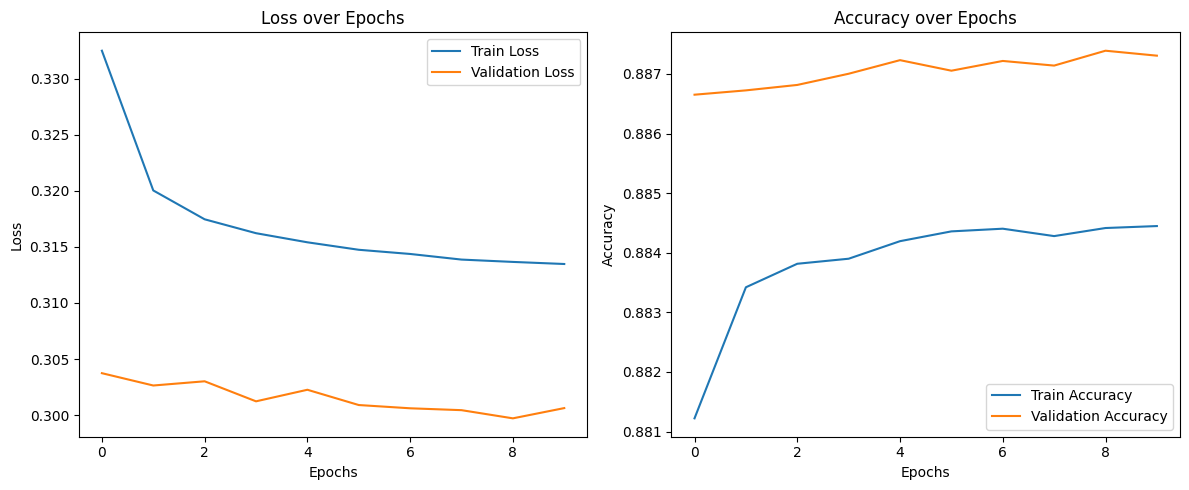

In [ ]:
plot_training_history(history)

11644/11644 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


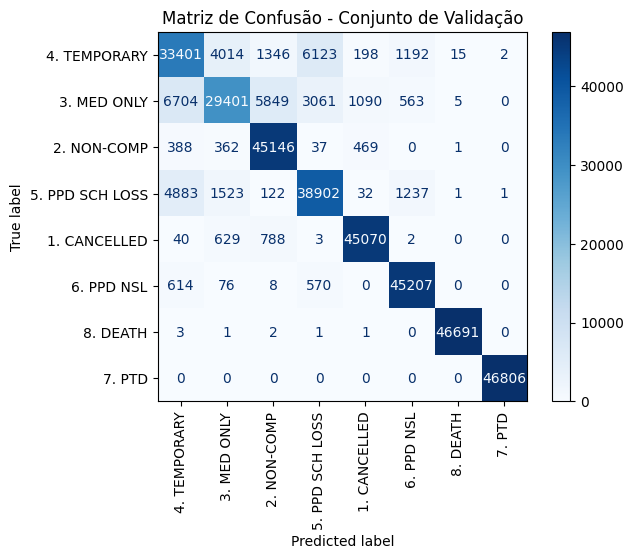

                 precision    recall  f1-score   support

   4. TEMPORARY       0.73      0.72      0.72     46291
    3. MED ONLY       0.82      0.63      0.71     46673
    2. NON-COMP       0.85      0.97      0.91     46403
5. PPD SCH LOSS       0.80      0.83      0.82     46701
   1. CANCELLED       0.96      0.97      0.97     46532
     6. PPD NSL       0.94      0.97      0.95     46475
       8. DEATH       1.00      1.00      1.00     46699
         7. PTD       1.00      1.00      1.00     46806

       accuracy                           0.89    372580
      macro avg       0.89      0.89      0.88    372580
   weighted avg       0.89      0.89      0.88    372580



In [170]:
plot_confusion_matrix(model=nn_model_xgbc, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping=mapping_dict, title="Matriz de Confusão - Conjunto de Validação"
)

In [171]:
save_predictions_to_csv(
    model=nn_model_xgbc,
    test_data=test_predictions_xgbc,
    claim_ids=data_test["Claim Identifier"],
    class_mapping=mapping_dict,
    output_path="../predictions/group_40_KFold_XGBC_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
Predições salvas em '../predictions/group_40_KFold_XGBC_NN_predictions.csv'.


In [ ]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_XGBC_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
1. CANCELLED       335775
3. MED ONLY         30605
4. TEMPORARY        21338
5. PPD SCH LOSS       257
Name: count, dtype: int64

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">Extra Tree Classifier</h3>

In [ ]:
oof_predictions_et, test_predictions_et = meta_model_run(
    model="ExtraTree",
    X_train_resampled=X_train_resampled,
    y_train_resampled=y_train_resampled,
    data_test_FS=data_test,
    n_splits=5
)

Training Fold 1...
Macro F1-Score do Fold 1: 0.9628
Training Fold 2...
Macro F1-Score do Fold 2: 0.9634
Training Fold 3...
Macro F1-Score do Fold 3: 0.9631
Training Fold 4...
Macro F1-Score do Fold 4: 0.9634
Training Fold 5...
Macro F1-Score do Fold 5: 0.9632
Treinamento concluído em 46.44 minutos.


In [ ]:
nn_model_et, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(oof_predictions_et, y_train_resampled)

history = nn_model_et.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

save_model(nn_model_et, "ExtraTree_NN_model")

Epoch 1/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 104s 4ms/step - accuracy: 0.9615 - loss: 0.1291 - val_accuracy: 0.9699 - val_loss: 0.0923 - learning_rate: 0.0010
Epoch 2/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 104s 4ms/step - accuracy: 0.9676 - loss: 0.1029 - val_accuracy: 0.9696 - val_loss: 0.0926 - learning_rate: 0.0010
Epoch 3/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.9679 - loss: 0.1007 - val_accuracy: 0.9701 - val_loss: 0.0908 - learning_rate: 0.0010
Epoch 4/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - accuracy: 0.9680 - loss: 0.1002 - val_accuracy: 0.9703 - val_loss: 0.0905 - learning_rate: 0.0010
Epoch 5/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 97s 4ms/step - accuracy: 0.9685 - loss: 0.0985 - val_accuracy: 0.9706 - val_loss: 0.0900 - learning_rate: 0.0010
Epoch 6/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 85s 4ms/step - accuracy: 0.9685 - loss: 0.0990 - val_accuracy: 0.9706 - val_loss: 0.0890 - learning_rate: 0.0010
Epoch 7/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step

'../models/ExtraTree_NN_model.pkl'

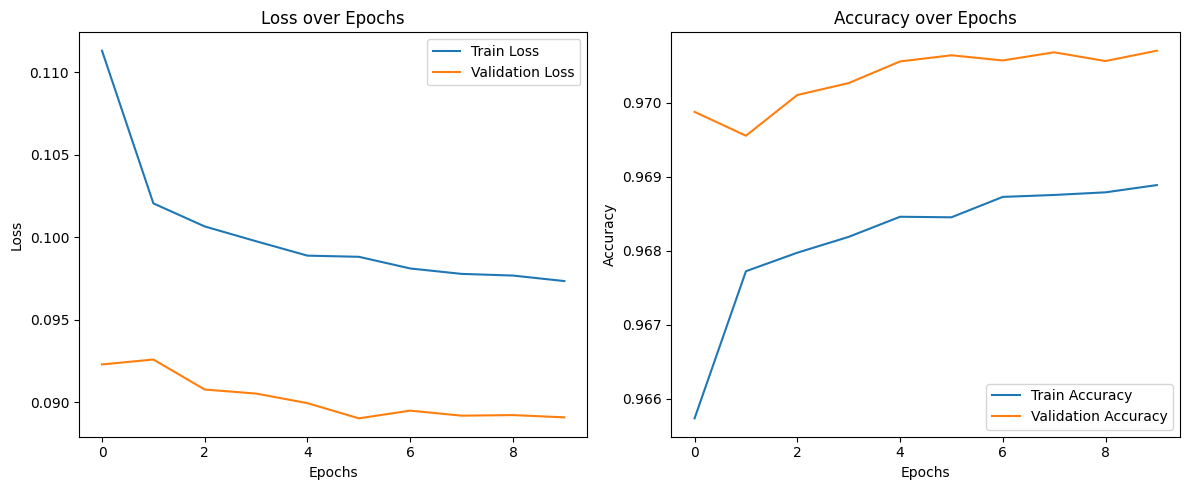

In [ ]:
plot_training_history(history)

11644/11644 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


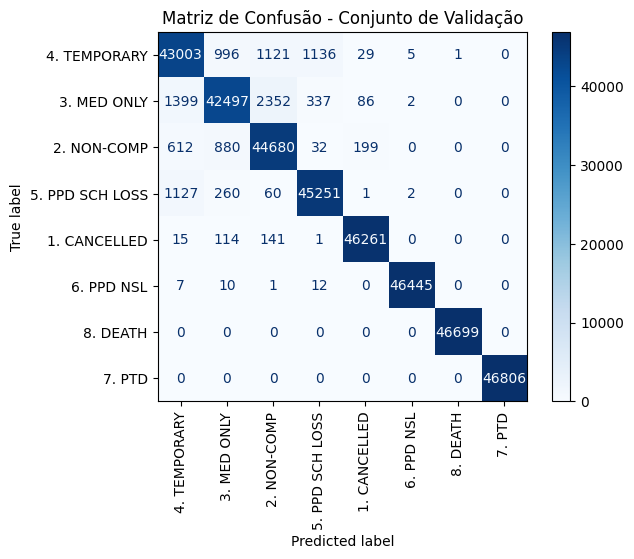

                 precision    recall  f1-score   support

   4. TEMPORARY       0.93      0.93      0.93     46291
    3. MED ONLY       0.95      0.91      0.93     46673
    2. NON-COMP       0.92      0.96      0.94     46403
5. PPD SCH LOSS       0.97      0.97      0.97     46701
   1. CANCELLED       0.99      0.99      0.99     46532
     6. PPD NSL       1.00      1.00      1.00     46475
       8. DEATH       1.00      1.00      1.00     46699
         7. PTD       1.00      1.00      1.00     46806

       accuracy                           0.97    372580
      macro avg       0.97      0.97      0.97    372580
   weighted avg       0.97      0.97      0.97    372580



In [176]:
plot_confusion_matrix(model=nn_model_et, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping=mapping_dict, title="Matriz de Confusão - Conjunto de Validação"
)

In [177]:
save_predictions_to_csv(
    model=nn_model_et,
    test_data=test_predictions_et,
    claim_ids=data_test["Claim Identifier"],
    class_mapping=mapping_dict,
    output_path="../predictions/group_40_KFold_ExtraTree_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
Predições salvas em '../predictions/group_40_KFold_ExtraTree_NN_predictions.csv'.


In [ ]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_ExtraTree_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
4. TEMPORARY       370610
5. PPD SCH LOSS     14502
3. MED ONLY          2748
1. CANCELLED          115
Name: count, dtype: int64

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">Ensemble Learning</h3>

<h5 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">Weighted Averaging Ensemble</h5>


In [179]:
#Cálculo do weight's através do desempenho
#Desempenho sem rede neuronal
f1_xgbc=0.88726
f1_rf=0.91618
f1_extratree=0.9288

#Desempenho com rede neuronal
f1_xgbc_nn=0.89
f1_rf_nn=0.93
f1_extratree_nn=0.94

total_f1 = f1_xgbc + f1_rf + f1_extratree
total_f1_nn = f1_xgbc_nn + f1_rf_nn + f1_extratree_nn

weights = [(((f1_xgbc / total_f1) + (f1_xgbc_nn / total_f1_nn)) / 2), (((f1_rf / total_f1) + (f1_rf_nn / total_f1_nn)) / 2), (((f1_extratree / total_f1) + (f1_extratree_nn / total_f1_nn)) / 2)]

In [180]:
ensemble_test_predictions = (
    weights[0] * test_predictions_xgbc +
    weights[1] * test_predictions_rf +
    weights[2] * test_predictions_et
)

ensemble_oof_predictions = (
    weights[0] * oof_predictions_xgbc +
    weights[1] * oof_predictions_rf +
    weights[2] * oof_predictions_et
)

In [181]:
final_test_predictions = ensemble_test_predictions
final_oof_predictions = ensemble_oof_predictions

In [ ]:
nn_model_weight_ensemble, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(final_oof_predictions, y_train_resampled)

history = nn_model_weight_ensemble.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

save_model(nn_model_weight_ensemble, "WeightedEnsemble_NN_model")

Epoch 1/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 108s 5ms/step - accuracy: 0.9413 - loss: 0.1790 - val_accuracy: 0.9502 - val_loss: 0.1379 - learning_rate: 0.0010
Epoch 2/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step - accuracy: 0.9486 - loss: 0.1487 - val_accuracy: 0.9520 - val_loss: 0.1342 - learning_rate: 0.0010
Epoch 3/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 126s 5ms/step - accuracy: 0.9489 - loss: 0.1468 - val_accuracy: 0.9512 - val_loss: 0.1354 - learning_rate: 0.0010
Epoch 4/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 127s 5ms/step - accuracy: 0.9495 - loss: 0.1452 - val_accuracy: 0.9523 - val_loss: 0.1326 - learning_rate: 0.0010
Epoch 5/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 125s 5ms/step - accuracy: 0.9500 - loss: 0.1432 - val_accuracy: 0.9521 - val_loss: 0.1324 - learning_rate: 0.0010
Epoch 6/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - accuracy: 0.9499 - loss: 0.1434 - val_accuracy: 0.9527 - val_loss: 0.1316 - learning_rate: 0.0010
Epoch 7/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms

'../models/WeightedEnsemble_NN_model.pkl'

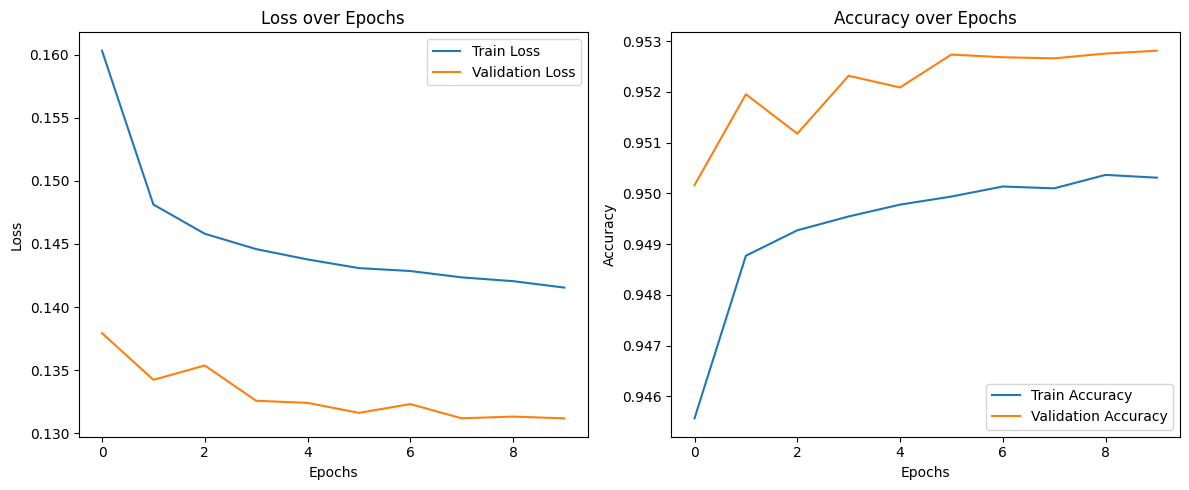

In [ ]:
plot_training_history(history)

11644/11644 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


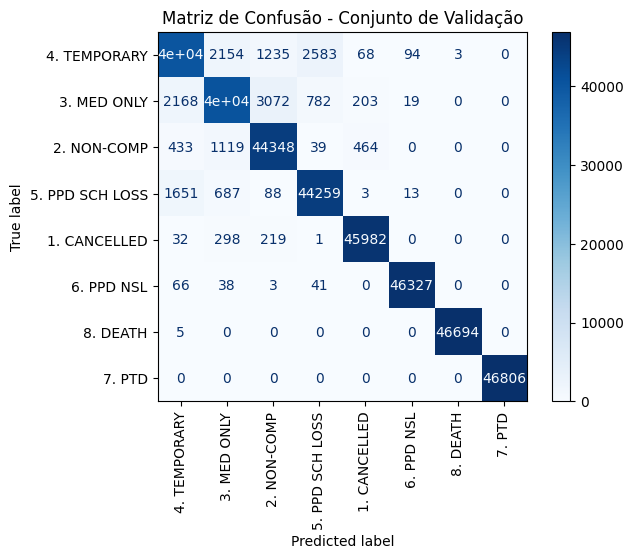

                 precision    recall  f1-score   support

   4. TEMPORARY       0.90      0.87      0.88     46291
    3. MED ONLY       0.90      0.87      0.88     46673
    2. NON-COMP       0.91      0.96      0.93     46403
5. PPD SCH LOSS       0.93      0.95      0.94     46701
   1. CANCELLED       0.98      0.99      0.99     46532
     6. PPD NSL       1.00      1.00      1.00     46475
       8. DEATH       1.00      1.00      1.00     46699
         7. PTD       1.00      1.00      1.00     46806

       accuracy                           0.95    372580
      macro avg       0.95      0.95      0.95    372580
   weighted avg       0.95      0.95      0.95    372580



In [184]:
plot_confusion_matrix(model=nn_model_weight_ensemble, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping=mapping_dict, title="Matriz de Confusão - Conjunto de Validação"
)

In [185]:
save_predictions_to_csv(
    model=nn_model_weight_ensemble,
    test_data=final_test_predictions,
    claim_ids=data_test["Claim Identifier"],
    class_mapping=mapping_dict,
    output_path="../predictions/group_40_KFold_Ensemble_Weight_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
Predições salvas em '../predictions/group_40_KFold_Ensemble_Weight_NN_predictions.csv'.


In [ ]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_Ensemble_Weight_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
4. TEMPORARY       229208
1. CANCELLED       135150
3. MED ONLY         22986
5. PPD SCH LOSS       631
Name: count, dtype: int64

<h5 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">Stacking Ensemble</h5>


In [187]:
X_meta_train = np.column_stack((oof_predictions_xgbc, oof_predictions_rf, oof_predictions_et))
X_meta_test = np.column_stack((test_predictions_xgbc, test_predictions_rf, test_predictions_et))

In [ ]:
nn_model_stacking_ensemble, X_nn_train, X_nn_val, y_nn_val, y_nn_train, early_stopping, reduce_lr = neural_network(X_meta_train, y_train_resampled)

history = nn_model_stacking_ensemble.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

save_model(nn_model_stacking_ensemble, "StackingEnsemble_NN_model")

Epoch 1/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - accuracy: 0.9627 - loss: 0.1248 - val_accuracy: 0.9725 - val_loss: 0.0846 - learning_rate: 0.0010
Epoch 2/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - accuracy: 0.9705 - loss: 0.0947 - val_accuracy: 0.9731 - val_loss: 0.0819 - learning_rate: 0.0010
Epoch 3/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - accuracy: 0.9712 - loss: 0.0919 - val_accuracy: 0.9735 - val_loss: 0.0822 - learning_rate: 0.0010
Epoch 4/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.9716 - loss: 0.0907 - val_accuracy: 0.9735 - val_loss: 0.0811 - learning_rate: 0.0010
Epoch 5/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.9718 - loss: 0.0892 - val_accuracy: 0.9735 - val_loss: 0.0809 - learning_rate: 0.0010
Epoch 6/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9719 - loss: 0.0890 - val_accuracy: 0.9738 - val_loss: 0.0802 - learning_rate: 0.0010
Epoch 7/10
23287/23287 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step -

'../models/StackingEnsemble_NN_model.pkl'

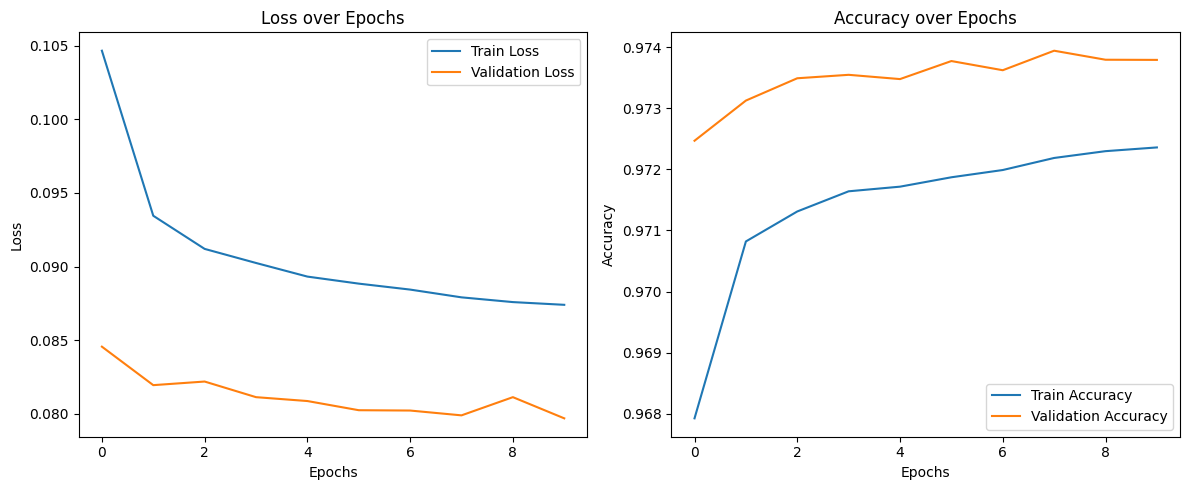

In [ ]:
plot_training_history(history)

11644/11644 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


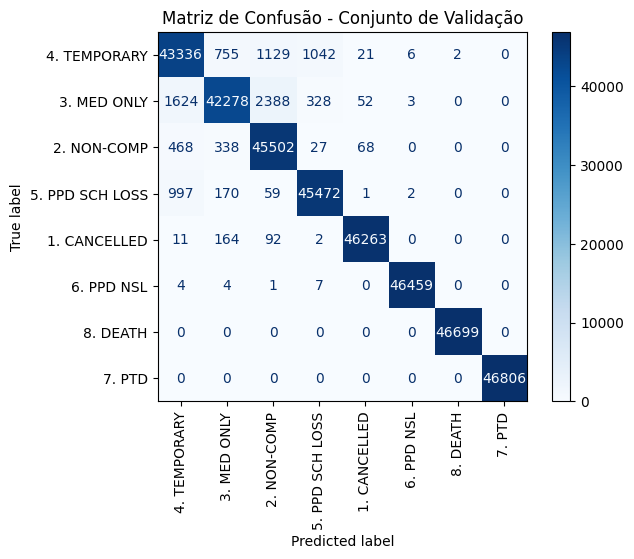

                 precision    recall  f1-score   support

   4. TEMPORARY       0.93      0.94      0.93     46291
    3. MED ONLY       0.97      0.91      0.94     46673
    2. NON-COMP       0.93      0.98      0.95     46403
5. PPD SCH LOSS       0.97      0.97      0.97     46701
   1. CANCELLED       1.00      0.99      1.00     46532
     6. PPD NSL       1.00      1.00      1.00     46475
       8. DEATH       1.00      1.00      1.00     46699
         7. PTD       1.00      1.00      1.00     46806

       accuracy                           0.97    372580
      macro avg       0.97      0.97      0.97    372580
   weighted avg       0.97      0.97      0.97    372580



In [190]:
plot_confusion_matrix(model=nn_model_stacking_ensemble, X_val=X_nn_val, y_val=y_nn_val,
    class_mapping=mapping_dict, title="Matriz de Confusão - Conjunto de Validação"
)

In [191]:
save_predictions_to_csv(
    model=nn_model_stacking_ensemble,
    test_data=X_meta_test,
    claim_ids=data_test["Claim Identifier"],
    class_mapping=mapping_dict,
    output_path="../predictions/group_40_KFold_Ensemble_Stacking_NN_predictions.csv"
)


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
Predições salvas em '../predictions/group_40_KFold_Ensemble_Stacking_NN_predictions.csv'.


In [ ]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_Ensemble_Stacking_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()
values

Claim Injury Type
4. TEMPORARY       317920
3. MED ONLY         54257
5. PPD SCH LOSS     15727
1. CANCELLED           71
Name: count, dtype: int64